In [34]:
%run data_preparation.ipynb

Accessible dataframes    Description                            # of columns  
data_2019                Gives data for 2019-Baseline           15
data_2020                Gives data for 2020                    15
data_2024                Gives data for 2024                    13
station_data             Existing stations in NYC from Lyft      6


In [2]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster


##### Ghost rides (taken from: https://towardsdatascience.com/interpolating-nyc-bike-share-data-to-discover-rebalancing-movements-6cf8a80eb902)

In [3]:
offset = pd.DataFrame({'starttime': pd.to_datetime('2010-09-01'),\
  'start station id':0,'stoptime': pd.to_datetime('2010-09-01'),\
  'end station id':0,'bikeid':0},index=[0])

In [4]:
dfbike1 = pd.concat([offset,data_2020]).reset_index(drop=True)
dfbike2 = pd.concat([data_2020,offset]).reset_index(drop=True)

dfbike=pd.concat ([dfbike1[['bikeid','stoptime','end station id']]\
            ,dfbike2[['bikeid','starttime','start station id']] ],\
             axis=1 )

In [44]:
dfbike.columns=['bikeid1','starttime','start station id',\
                'bikeid2','stoptime','end station id']
dfrebal = dfbike[['starttime','start station id',\
                  'stoptime','end station id']].\
           loc[(dfbike.bikeid1==dfbike.bikeid2) & \
          (dfbike['start station id'] != dfbike['end station id']) ]
dfrebal.reset_index(drop=True, inplace=True)

In [45]:
dfstations = combine_csv_files(folder_path)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
dfstations = dfstations[['start station id','start station name']] 
dfstations.columns=['station id','station name']
dfstations.drop_duplicates(inplace=True)
dfstations.set_index('station id',drop=True, inplace=True)
len(dfstations)

52

In [ ]:
dfrebal = pd.merge(dfrebal, dfstations[['station name']],\
     how = 'left', left_on='start station id', right_on='station id')
dfrebal = pd.merge(dfrebal, dfstations[['station name']],\
     how = 'left', left_on='end station id', right_on='station id')

In [ ]:
dfrebal.rename(columns = 
        {'station name_x':'start station name',\
         'station name_y':'end station name'},\
          inplace = True)

In [ ]:
dfrebal

,starttime,start station id,stoptime,end station id,start station name,end station name
0,2020-08-12 02:42:57.923,3205,2020-08-12 03:27:46.516,3279,JC Medical Center,Dixon Mills


In [ ]:
rebalin = dfrebal['end station name'].value_counts()[:20]
rebalout = dfrebal['start station name'].value_counts()[:20]

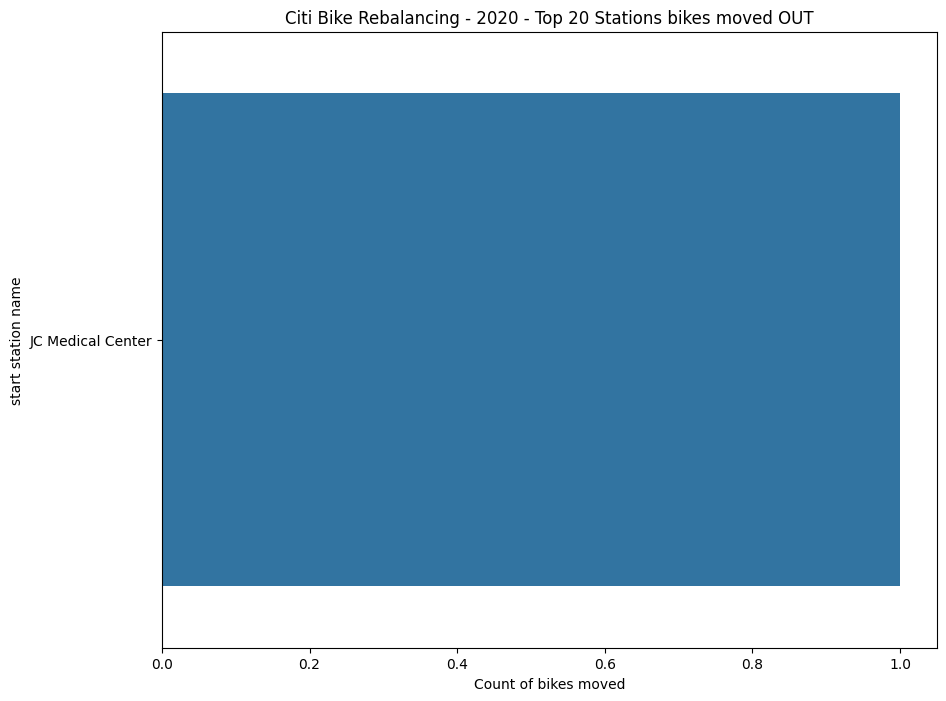

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Citi Bike Rebalancing - 2020\
 - Top 20 Stations bikes moved OUT'  ) 
plt.xlabel('Count of bikes moved') 
sns.barplot( x=rebalout.values, y=rebalout.index,  orient="h" ) ;

## Grouped stations

In [ ]:
# Group by start_station_id and started_at, and calculate count, start_lat, and start_lng for each group
grouped_data = data_2024.groupby(['start_station_name', 'started_at']).agg({
    'start_lat': 'first',
    'start_lng': 'first',
    'ride_id': 'count'  # Count the number of objects standing at each station at each time point
}).reset_index()

# Rename the 'ride_id' column to 'count' for clarity
grouped_data.rename(columns={'ride_id': 'count'}, inplace=True)

# Find the maximum count of objects standing at any given time for each station
max_objects_count = grouped_data.groupby('start_station_name')['count'].max()
max_objects_count

C:\Users\lukas\AppData\Local\Temp\ipykernel_19000\1913609655.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_2024.groupby(['start_station_name', 'started_at']).agg({
C:\Users\lukas\AppData\Local\Temp\ipykernel_19000\1913609655.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  max_objects_count = grouped_data.groupby('start_station_name')['count'].max()


start_station_name
11 St & Washington St                2
12 St & Sinatra Dr N                 1
14 St Ferry - 14 St & Shipyard Ln    2
2 St & Park Ave                      2
4 St & Grand St                      1
                                    ..
Van Vorst Park                       2
Warren St                            2
Washington St                        1
Willow Ave & 12 St                   1
York St & Marin Blvd                 2
Name: count, Length: 89, dtype: int64

In [ ]:
data_2024.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [ ]:

station_locations = data_2024[['start_lat', 'start_lng']].drop_duplicates()
k = 5  # Update based on your Elbow Method result
kmeans = KMeans(n_clusters=k, random_state=0).fit(station_locations)

station_locations['cluster'] = kmeans.labels_
station_locations

,start_lat,start_lng,cluster
0,40.712297,-74.038185,0
1,40.715391,-74.049692,4
2,40.712419,-74.038526,0
6,40.742659,-74.032233,1
8,40.742664,-74.032290,1
...,...,...,...
50648,40.751983,-74.030271,1
50651,40.737605,-74.041718,3
50654,40.737612,-74.041668,3
50656,40.751920,-74.030396,1


In [ ]:
data_2020.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [8]:
# Assuming station_locations contains the DataFrame with 'start_lat' and 'start_lng' columns
station_locations = data_2019[['start station latitude', 'start station longitude']].drop_duplicates()

# Fit KMeans clustering
k = 5  # Update based on your Elbow Method result
kmeans = KMeans(n_clusters=k, random_state=0).fit(station_locations)
station_locations['cluster'] = kmeans.labels_

# Create a map centered around New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(nyc_map)

# Add markers to the MarkerCluster
for idx, row in station_locations.iterrows():
    popup_text = f'Cluster {row["cluster"]}'
    folium.Marker(location=[row['start station latitude'], row['start station longitude']], popup=popup_text).add_to(marker_cluster)

nyc_map

# HTML File with stations (Lyft)

In [15]:
data_2019.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [20]:
station_data_19 = data_2019[['start station name','start station longitude','start station latitude']]
station_data_19 = station_data_19.drop_duplicates()

station_data_19['capacity'] = 1
# Sample data
locations = station_data_19['start station name']
latitudes = station_data_19['start station latitude']
longitudes = station_data_19['start station longitude']
sizes = station_data_19['capacity']
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("nyc_bike_stations_19.html")

In [35]:
station_data_20 = data_2020[['start station name','start station longitude','start station latitude']]
station_data_20 = station_data_20.drop_duplicates()

station_data_20['capacity'] = 1
# Sample data
locations = station_data_20['start station name']
latitudes = station_data_20['start station latitude']
longitudes = station_data_20['start station longitude']
sizes = station_data_20['capacity']
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("nyc_bike_stations_20.html")

In [33]:

station_data_24 = data_2024[['start_station_name','start_lat','start_lng']]
station_data_24 = station_data_24.drop_duplicates(subset='start_station_name')
station_data_24['capacity'] = 1
# len(station_data_24['start_station_name'].unique())
# len(station_data_24)

# Sample data
locations = station_data_24['start_station_name']
latitudes = station_data_24['start_lat']
longitudes = station_data_24['start_lng']
sizes = station_data_24['capacity']
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("nyc_bike_stations_24.html")

In [23]:
station_data['capacity'] = 1

# Sample data
locations = station_data['name']
latitudes = station_data['lat']
longitudes = station_data['lon']
sizes = station_data['capacity']
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("nyc_bike_stations.html")

##### Map 2022

In [46]:
# current_directory = os.getcwd()
# file_name = "data/2022"
# folder_path = os.path.join(current_directory, file_name)

# data_2022 = combine_csv_files(folder_path)
# station_data_22 = data_2022[['start_station_name','start_lat','start_lng']]
# station_data_22 = station_data_22.drop_duplicates(subset='start_station_name')
# station_data_22['capacity'] = 1
# # len(station_data_22['start_station_name'].unique())
# # len(station_data_22)

# # Sample data
# locations = station_data_22['start_station_name']
# latitudes = station_data_22['start_lat']
# longitudes = station_data_22['start_lng']
# sizes = station_data_22['capacity']
# #values = [20, 30, 25, 40]  # Values for the color scale

# # Initialize the map centered around the first location
# mymap = folium.Map()

# # Iterate over locations
# for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
#     # Add circle marker with varying sizes
#     folium.CircleMarker(
#         location=[lat, lon],
#         radius=size / 10,  # Normalize size for better visualization
#         color='blue',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.6,
#         popup=location
#     ).add_to(mymap)

# # Save the map to an HTML file
# mymap.save("nyc_bike_stations_22.html")